# [FAISS Index](https://github.com/facebookresearch/faiss/wiki/Faiss-indexes/1f721de164ae7950c65914d2dde0865312584a36)

 ### Download `Sift1M` Dataset

In [1]:
import os
import shutil
import tarfile
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import seaborn as sns
import faiss

from urllib import request 
from contextlib import closing
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

In [2]:
url_endpoint = "ftp://ftp.irisa.fr/local/texmex/corpus/sift.tar.gz"
file_path = "sift.tar.gz"

if not os.path.exists(file_path):
    # Download Sift1M dataset
    with closing(request.urlopen(url_endpoint)) as r:
        with open(file_path, "wb") as fp, tqdm(
            unit="B", unit_scale=True, 
            unit_divisor=1024, miniters=1, 
            desc=file_path,
            total=int(r.info().get('Content-Length', -1))
        ) as progress:
            chunk_size = 1 * 1024 * 1024  # 1 MB chunks
            while True:
                chunk = r.read(chunk_size)
                if not chunk:
                    break
                fp.write(chunk)
                progress.update(len(chunk))

In [3]:
# unzip file
tar = tarfile.open("sift.tar.gz", "r:gz")
tar.extractall()

In [4]:
def read_fvecs(fp):
    a = np.fromfile(fp, dtype="int32")
    d = a[0]
    return a.reshape(-1, d+1)[:, 1:].copy().view("float32")

In [5]:
# data we will search through
xb = read_fvecs('./sift/sift_base.fvecs')  # 1M samples

# also get some query vectors to search with
xq = read_fvecs('./sift/sift_query.fvecs')

# take just one query (there are many in sift_learn.fvecs)
xq = xq[0].reshape(1, xq.shape[1])

In [6]:
print("xb shape: ", xb.shape)
print("xq shape: ", xq.shape)

xb shape:  (1000000, 128)
xq shape:  (1, 128)


In [7]:
# length of embeddings
d = xq.shape[1]

### Flat L2 Index Initialization

Perform an exhaustive search of the query. This approach takes more time but yields the most accurate results.

In [8]:
NO_OF_RETRIVAL = 10

In [9]:
index = faiss.IndexFlatL2(d)

print("Is index Trained: ", index.is_trained)
# add vector in the index
index.add(xb)
print(f"Total index: {index.ntotal}")

Is index Trained:  True
Total index: 1000000


In [10]:
%%time
distance, idx_retrive_flatl2 = index.search(xq, k=NO_OF_RETRIVAL)
print(idx_retrive_flatl2)

[[932085 934876 561813 708177 706771 695756 435345 701258 455537 872728]]
CPU times: user 29.6 ms, sys: 290 μs, total: 29.9 ms
Wall time: 30.6 ms


### LSH (Locality Sensitive Hashing)
LSH is a technique used for approximate nearest neighbor search. **It hashes data points into buckets in such a way that similar data points are more likely to be hashed into the same bucket.** This allows for faster retrieval of approximate nearest neighbors.

In Faiss, the IndedLSH is just a Flat index with binary codes. The database vectors and query vectors are hashed into binary codes that are compared with Hamming distances.
```python
IndexLSH * index = new faiss::IndexLSH (d, nbits);
```
where `d` is the input vector dimensionality and `nbits` the number of bits use per stored vector.

> Greater the n_bits more precision but it takes more space to store vector.

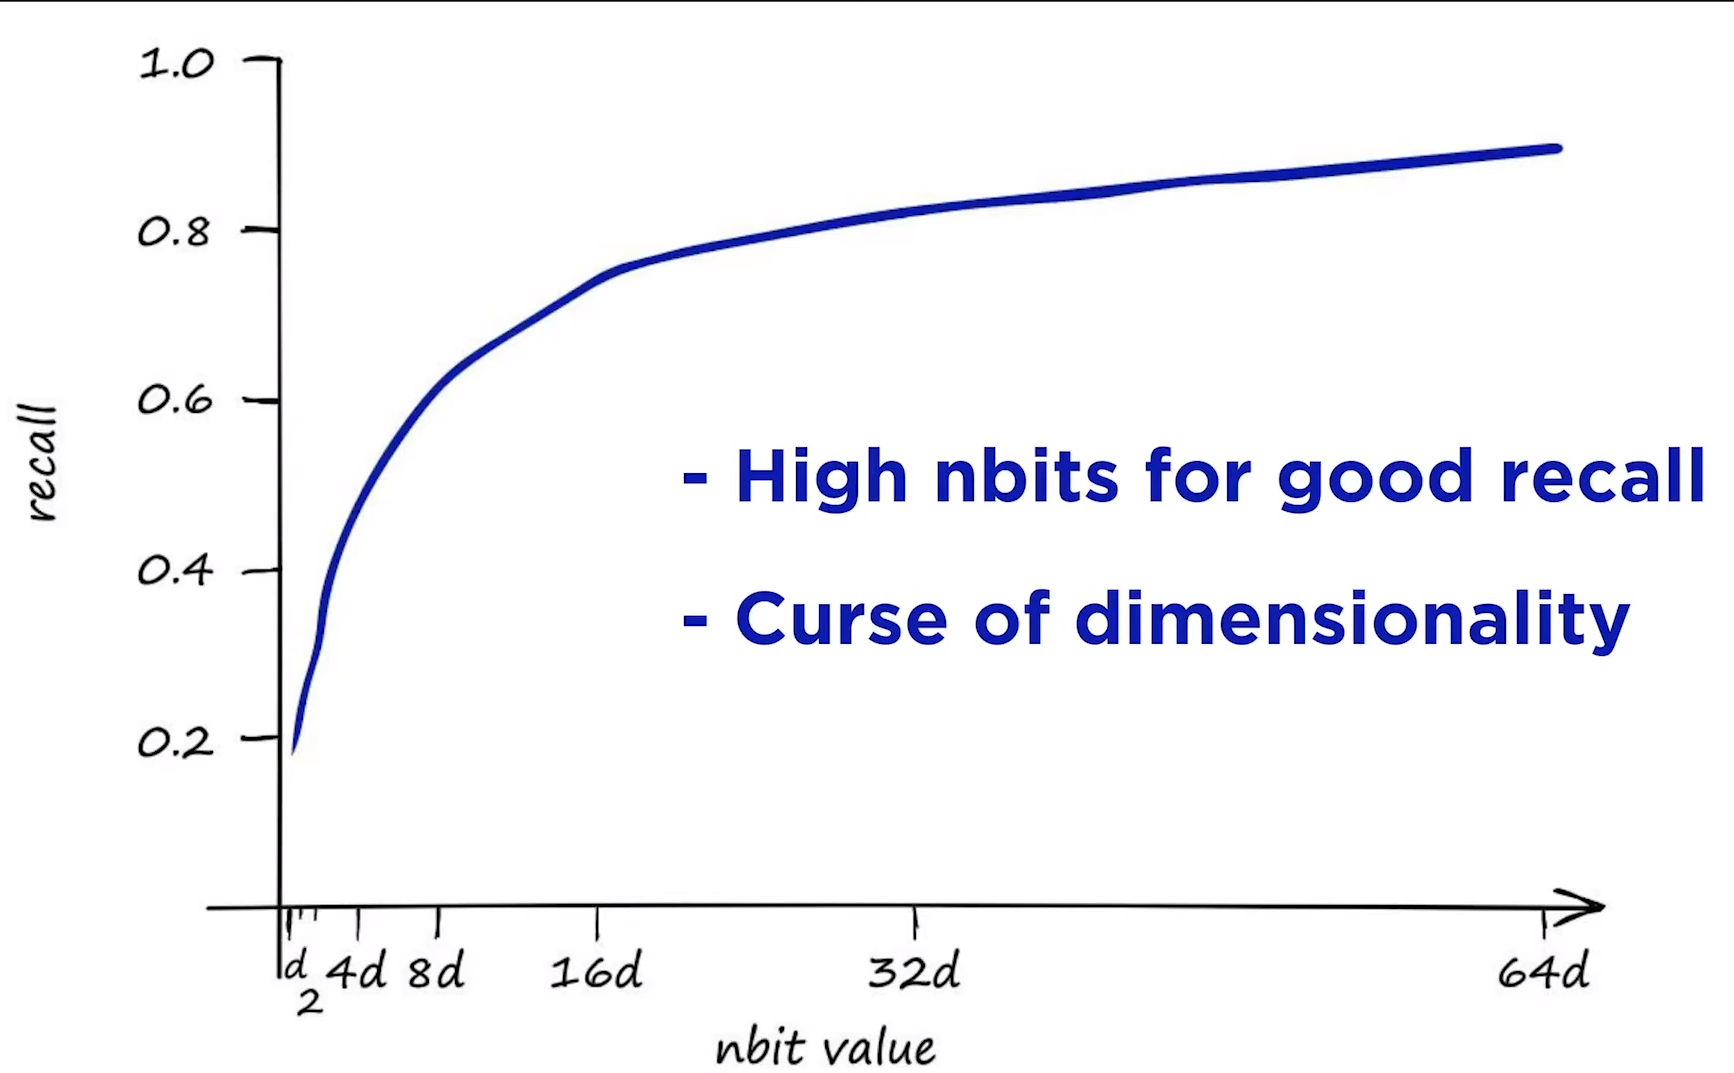
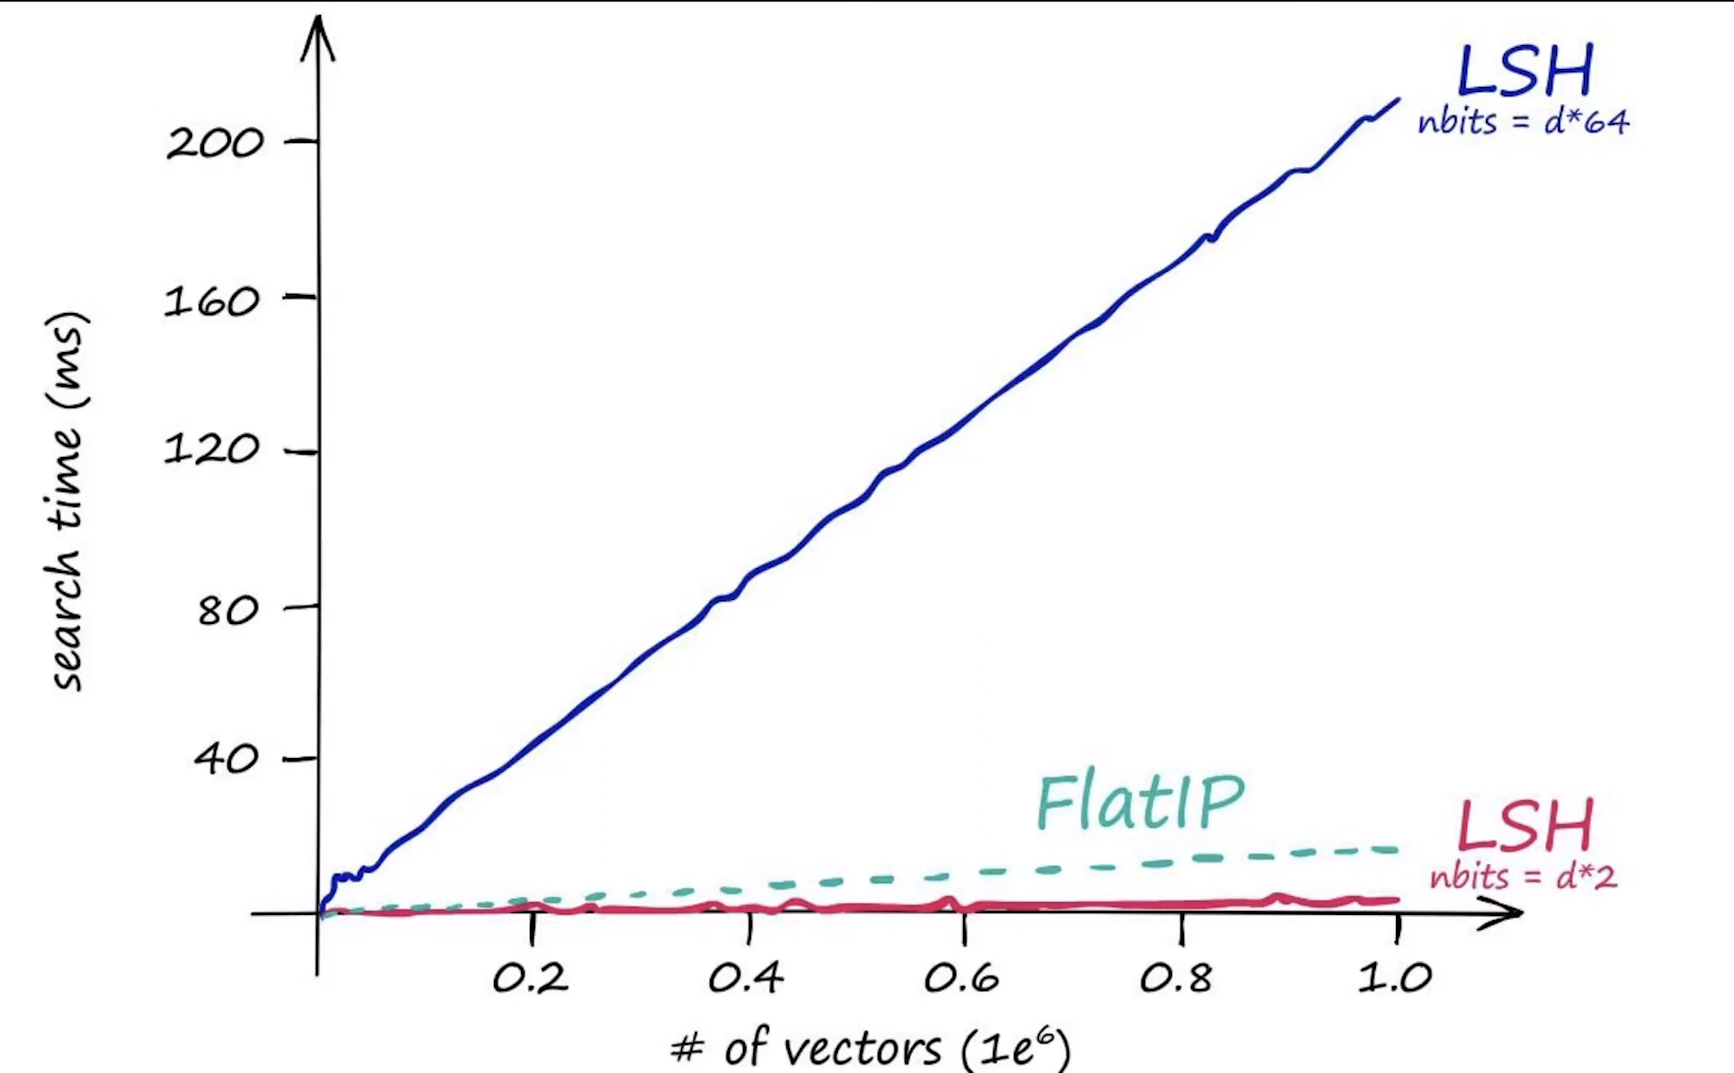


In [11]:
n_bits = 2*d
index = faiss.IndexLSH(d, n_bits) 

# train the index if not trained
if not index.is_trained:
    index.train(xb)
# Add vectors to the index
index.add(xb)
print("Total index:", index.ntotal)

Total index: 1000000


In [12]:
%%time
distance, idx_retrive_lsh = index.search(xq, k=NO_OF_RETRIVAL)
print(idx_retrive_lsh)

[[561813 631060 880292  12840 893601 910119 932085   2176  12980 238750]]
CPU times: user 1.36 s, sys: 3.12 ms, total: 1.36 s
Wall time: 125 ms


In [13]:
# compare how many of idx is same in `flatl2` and `lsh`
array_bool = np.in1d(idx_retrive_lsh, idx_retrive_flatl2)
print("No of same index retrived ouit of 10 is: ", sum(array_bool))

No of same index retrived ouit of 10 is:  2


### HNSW (Hierarchical Navigable Small World)
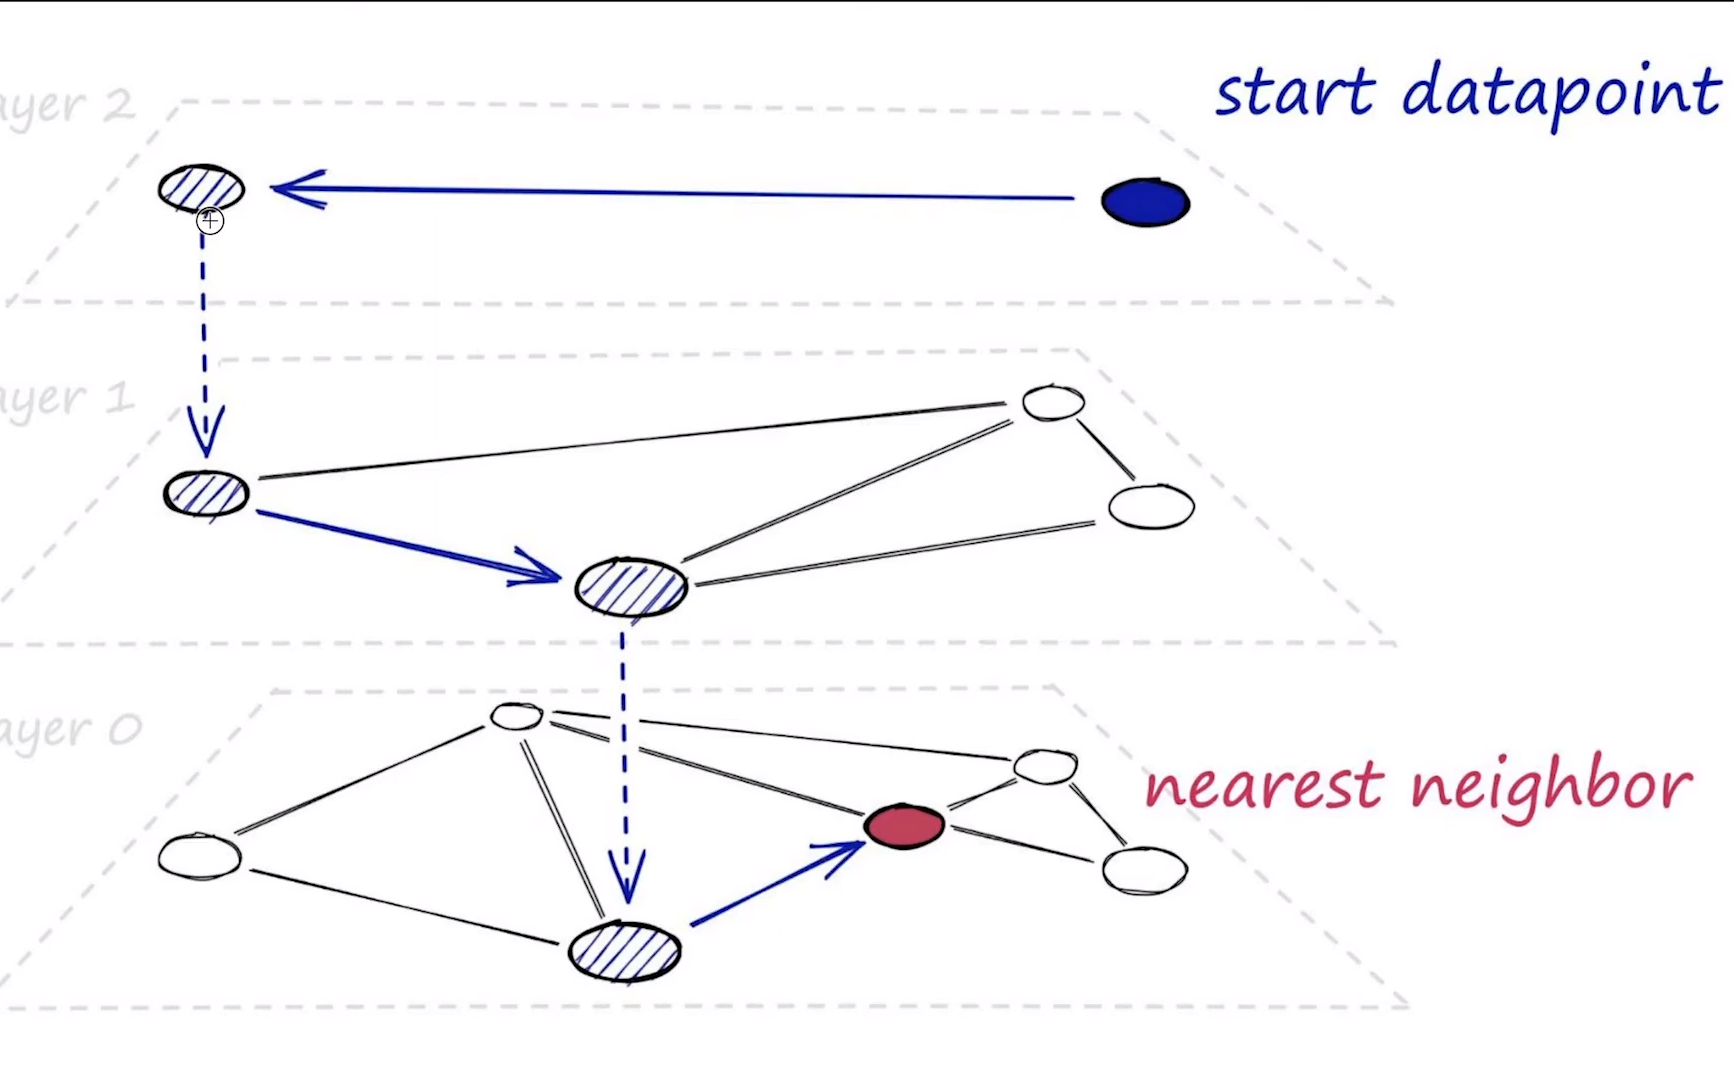

In [14]:
# number of connection each node has
M = 16
# depth of search (high value if search for more of network(more accurate result), 
# low value if to search less of network-(less accurate result))
ef_search = 32
# how much we search during construction of network
# good to have high value
ef_construction = 64

In [15]:
index = faiss.IndexHNSWFlat(d, M)

index.hnsw.efSearch = ef_search
index.hnsw.erfConstruction = ef_construction

index.add(xb)

In [16]:
%%time
distance, idx_retrive_hnsw = index.search(xq, k=NO_OF_RETRIVAL)
print(idx_retrive_hnsw)

[[934876 561813 708177 706771 435345 701258 455537  36538 562594 908244]]
CPU times: user 12.2 ms, sys: 4 μs, total: 12.2 ms
Wall time: 870 μs


In [17]:
# compare how many of idx is same in `flatl2` and `hnsw`
array_bool = np.in1d(idx_retrive_lsh, idx_retrive_hnsw)
print("No of same index retrived ouit of 10 is: ", sum(array_bool))

No of same index retrived ouit of 10 is:  1


### Inverted File Index (IVF)

The Inverted File Index (IVF) in FAISS organizes vectors into clusters or "cells" using a coarse quantizer, allowing for efficient retrieval by limiting searches to relevant clusters. This approach speeds up similarity searches by reducing the number of comparisons needed, especially in large datasets.

In [18]:
# no of centroid in database
nlist = 128

quantizer = faiss.IndexFlatIP(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist)

# train index
index.train(xb)
# add embedding in index1
index.add(xb)
# no. of probe we are going to srearch
index.nprobe = 2

In [19]:
%%time
distance, idx_retrive_ivf = index.search(xq, k=NO_OF_RETRIVAL)
print(idx_retrive_ivf)

[[932085 934876 561813 708177 706771 435345 701258 455537 872728  36538]]
CPU times: user 30.6 ms, sys: 972 μs, total: 31.6 ms
Wall time: 3.09 ms


In [20]:
# compare how many of idx is same in `flatl2` and `ivf`
array_bool = np.in1d(idx_retrive_lsh, idx_retrive_ivf)
print("No of same index retrived ouit of 10 is: ", sum(array_bool))

No of same index retrived ouit of 10 is:  2


## FAISS Speed Tests
Testing different index structures in FAISS
- `IndexFlatL2`
- `IndexIVFFLat`
- `IndexIVFPQ`

In [21]:
# define the property to make nice
colors = ['#041BB3', '#E31957', '#12B0A7', '#000000']
sns.set_palette(sns.color_palette(colors))
sns.set_theme(font_scale=1.4)

### Generate random dense vector as Data

In [22]:
def make_array(num_of_vec: int, dim:int = 100):
    return np.random.random((num_of_vec, dim)).astype("float32")

In [23]:
def test(index, step: int=1_000, high: int=1_000_000, k:int =5, epochs: int=20):
    timer = np.zeros((epochs, int(high/step)))
    dim = np.zeros(int(high/step))
    # make sample query 
    x_query = make_array(1)

    for epoch in tqdm(range(epochs)):
        index.reset()
        iter_step = 0
        for i in range(step, high, step):
            wb = make_array(step)
            if not index.is_trained:
                index.train(wb)
            # add data to index
            index.add(wb)
            # start timer 
            start_time = datetime.now()
            distance, idx_retriv = index.search(x_query, k) # search in index
            end_time = datetime.now()
            time_taken = (end_time - start_time).microseconds
            timer[epoch, iter_step] = time_taken
            dim[iter_step] = 1
            iter_step += 1
    timer = np.median(timer, axis=0)
    return dim, timer

In [24]:
d = 100
test_df = pd.DataFrame({
    "num_vectors": [],
    "query_time": [],
    "test": []
})

### Flat L2 Index

The Flat L2 Index in FAISS performs exact nearest neighbor searches by computing L2 (Euclidean) distances between the query vector and all vectors in the dataset, providing high accuracy but potentially high computational cost. This index is straightforward and suitable for small to medium-sized datasets where exact results are needed.

In [25]:
# initialize faiss index
index = faiss.IndexFlatL2(d)

dim, time = test(index)

  0%|          | 0/20 [00:00<?, ?it/s]

In [26]:
dim[:5]

array([1., 1., 1., 1., 1.])

In [27]:
time[:5]

array([22.5, 26.5, 37.5, 51.5, 65.5])

In [28]:
df = pd.DataFrame({
    "num_vectors": dim.tolist(),
    "query_time": time.tolist(),
})
# assign FlatL2 as value in all cols of df
df["test"] = "FlatL2"
# concat two dataframe
test_df = pd.concat([test_df, df], ignore_index=True)

print(f"Shape of test_df: {test_df.shape}")
test_df.head()

Shape of test_df: (1000, 3)


,num_vectors,query_time,test
0,1.0,22.5,FlatL2
1,1.0,26.5,FlatL2
2,1.0,37.5,FlatL2
3,1.0,51.5,FlatL2
4,1.0,65.5,FlatL2


Text(0, 0.5, 'Query time(ms)')

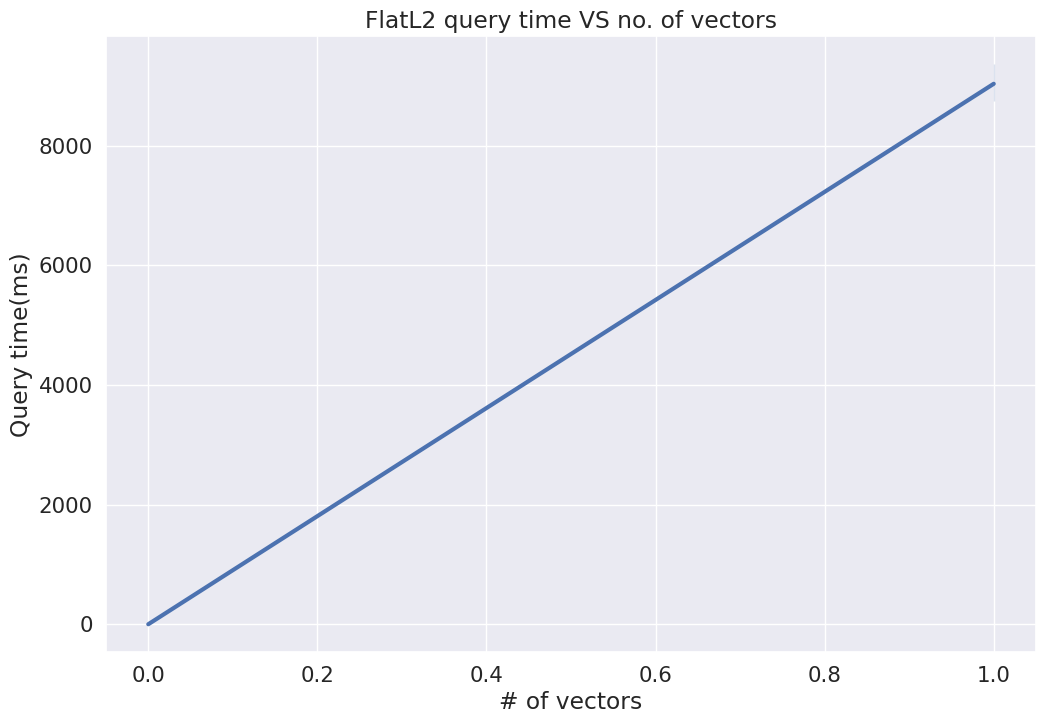

In [29]:
# plot the figure
plt.figure(figsize=(12, 8))
ax = sns.lineplot(x="num_vectors",
                  y="query_time",
                  data=test_df[test_df["test"] == "FlatL2"],
                  linewidth=3)

ax.set_title("FlatL2 query time VS no. of vectors")
# for label
ax.set_xlabel("# of vectors")
ax.set_ylabel("Query time(ms)")

### IndexIVFFlat

`IndexIVFFlat` in FAISS combines Inverted File Indexing (IVF) with a Flat (brute-force) search within each cluster. It first clusters the vectors into cells for efficient searching, and then performs an exact search within the selected clusters, balancing between speed and accuracy for large datasets.

In [30]:
n_list = 50
quantizer = faiss.IndexFlatL2(d)
index = faiss.IndexIVFFlat(quantizer, d, n_list)

In [31]:
for nprobe in [1, 5, 10, 15, 20]:
    index.nprobe = nprobe
    dim, time = test(index)
    df = pd.DataFrame({
        "num_vectors": dim.tolist(),
        "query_time": time.tolist(),
    })
    df["test"] = "IVFFlat"
    # concat two dataframe
    test_df = pd.concat([test_df, df], ignore_index=True)

  0%|          | 0/20 [00:00<?, ?it/s]

WARNING clustering 1000 points to 50 centroids: please provide at least 1950 training points


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Text(0, 0.5, 'query time (ms)')

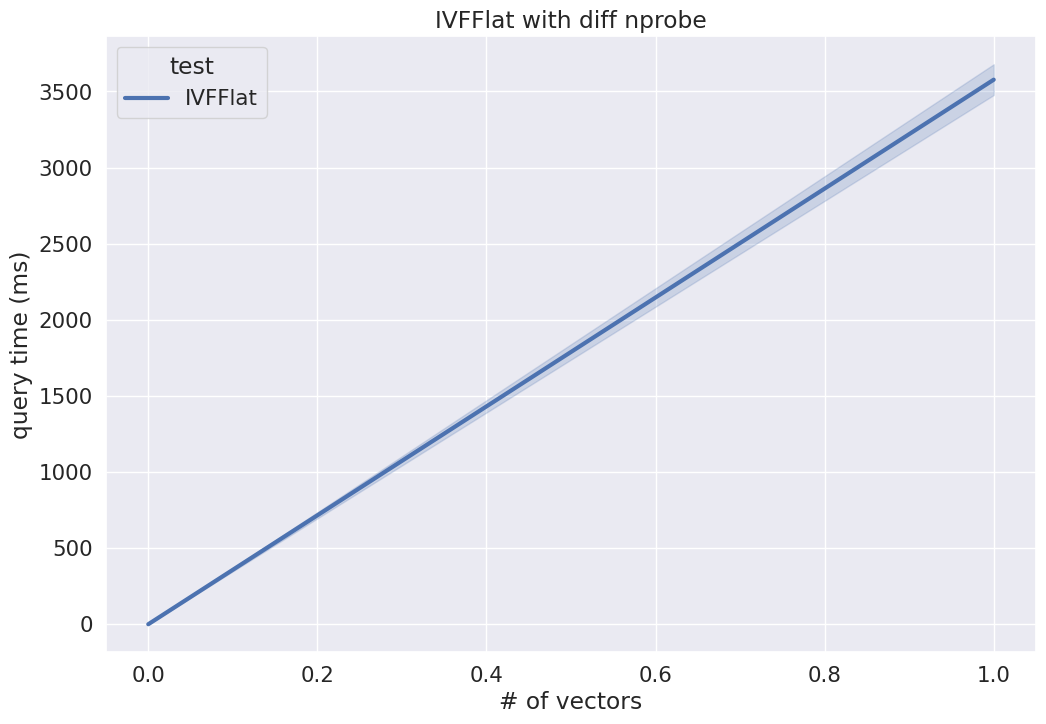

In [32]:
# plot for various nprobe time
plt.figure(figsize=(12, 8))
ax = sns.lineplot(x='num_vectors', 
                  y='query_time', 
                  data=test_df[test_df['test'].str.contains('IVFFlat')], 
                  linewidth=3, 
                  hue='test')
ax.set_title('IVFFlat with diff nprobe')
ax.set_xlabel('# of vectors')
ax.set_ylabel('query time (ms)')

### IndexIVFPQ
`IndexIVFPQ` in FAISS combines Inverted File Indexing (IVF) with Product Quantization (PQ) to efficiently search large datasets by first clustering vectors and then quantizing them for fast approximate nearest neighbor retrieval. It reduces search time and memory usage by approximating distances and focusing searches within relevant clusters.

In [33]:
# number of centrois IDs in final compressed vectors
m = 5
# number of bits in each centroid
nbits = 8

quantizer = faiss.IndexFlatL2(d)  # we keep the same L2 distance flat index
index = faiss.IndexIVFPQ(quantizer, d, nlist, m, nbits)

In [34]:

dim, time = test(index)
df = pd.DataFrame({
    'num_vectors': dim.tolist(),
    'query_time': time.tolist()
})
df['test'] = 'IVFPQ'
test_df = pd.concat([test_df, df], ignore_index=True)

  0%|          | 0/20 [00:00<?, ?it/s]

WARNING clustering 1000 points to 128 centroids: please provide at least 4992 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points


Text(0.5, 1.0, 'IndexIVFPQ timme vs #of query graph')

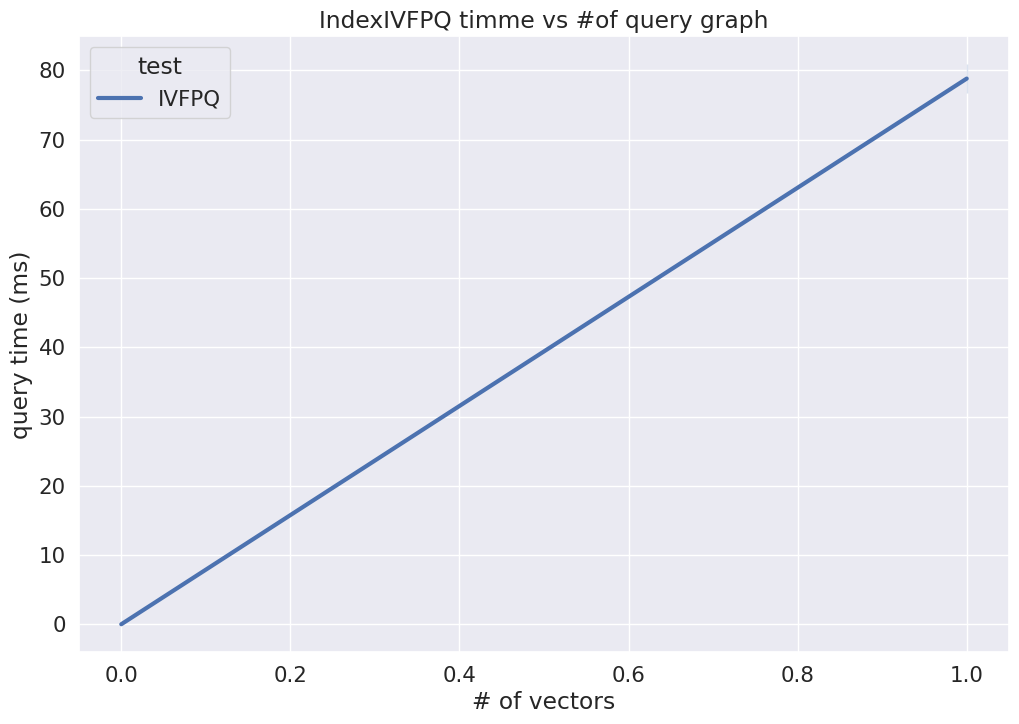

In [35]:
# plot for IVFPQ
plt.figure(figsize=(12, 8))
ax = sns.lineplot(x='num_vectors', 
                  y='query_time', 
                  data=test_df[test_df['test'] == 'IVFPQ'], 
                  linewidth=3, 
                  hue='test')
ax.set_xlabel('# of vectors')
ax.set_ylabel('query time (ms)')
ax.set_title("IndexIVFPQ timme vs #of query graph")

### Plot ALL

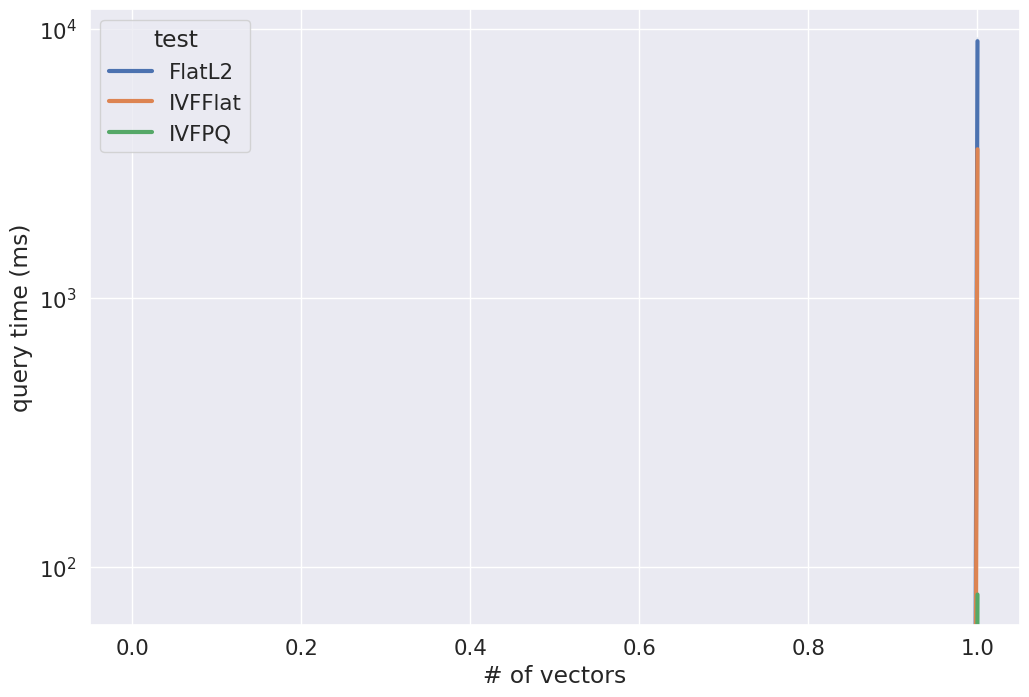

In [36]:
plt.figure(figsize=(12, 8))
ax = sns.lineplot(x='num_vectors', 
                  y='query_time', 
                  data=test_df[~test_df['test'].isin(['IVFFlat_1', 'IVFFlat_5', 'IVFFlat_20'])], 
                  linewidth=3, 
                  hue='test')
ax.set_xlabel('# of vectors')
ax.set_ylabel('query time (ms)')
plt.yscale('log')